In [1]:
import numpy as np
import sys
from scipy import integrate
import matplotlib.pyplot as plt
from math import log10, log2, pi
%matplotlib inline

In [2]:
np.set_printoptions(16)

In [3]:
print("Python  float epsilon: {}".format(sys.float_info[8]))
print("Numpy float64 epsilon: {}".format(np.finfo(np.float64).eps))

Python  float epsilon: 2.220446049250313e-16
Numpy float64 epsilon: 2.220446049250313e-16


In [4]:
def f1(x):
    #todo division by zero
    return (np.cos(x)-1)/(np.sqrt(x))

def f2_func(theta_m):
    def f(theta):
        return np.sqrt(8/(1e-8+np.cos(theta)-np.cos(theta_m)))
    return f

true_f1 =  0.26874616993238043
print("True value of f1 (including analytical part), error 1e-14, calculated using romberg: ",  true_f1)

True value of f1 (including analytical part), error 1e-14, calculated using romberg:  0.26874616993238043


In [5]:
def plot(I, N, title, true_value=None, log=True):
    if log:
        y = [log10(abs(i)) for i in I]
    else:
        y = [i for i in I]
    x = [log2(i/10) for i in N]
    
    plt.plot(x, y, label="Computed value")
    if true_value is not None:
        if log:
            y2 = [log10(abs(true_value))]*(len(I))
        else:
            y2 = [true_value]*(len(N))
        plt.plot(x, y2, label="True value")
    plt.plot
    if log:
        plt.ylabel("log10(|I|)")
    else:
        plt.ylabel("|I|")
    plt.xlabel("log2(N/10)")
    plt.title(title)
    plt.legend()
    plt.show()

### Left rectangle rule

In [6]:
def integrate_rect(f, lower, upper, N, verbose=False):
    """Integrates using left rectangle rule"""
    x_k, h = np.linspace(lower, upper, N, False, retstep=True, dtype=np.float64)
    assert h==abs(upper-lower)/N
    if verbose: print(h)
    f_k = f(x_k)
    return h*np.sum(f_k) 

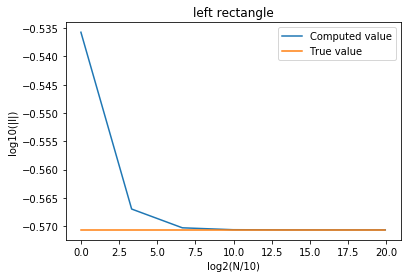

best estimate: 0.2687461929172883, error:2.2984907865897242e-08, N: 10000000


In [7]:
I = [integrate_rect(f1, 1e-14, 1, 10**i)+ 1-np.cos(1) for i in range(1,8)]
N = [10**i for i in range(1,8)]
plot(I, N, "left rectangle", true_value=true_f1)
print("best estimate: {}, error:{}, N: {}".format(I[-1], I[-1]-true_f1, N[-1]))

### Trapezoidal rule

In [8]:
def integrate_trap(f, lower, upper, N, oddterms=False, verbose=False):
    h = abs(upper-lower)/N
    if verbose: print('h = {}'.format(h))
    if oddterms:
        x_k = np.arange(lower+h, upper-0.5*h, 2*h, dtype=np.float64)
    else:
        x_k = np.arange(lower, upper+0.5*h, h, dtype=np.float64)
        
    if verbose==2: print("points: ", x_k)
    A_k = f(x_k)
    if verbose: print("scipy integrate: ", integrate.trapz(A_k, dx=h))
        
    if not oddterms:
        A_k[0] *= 0.5
        A_k[-1] *= 0.5
        
    result = h*A_k.sum()
    if verbose: print('my result: ', result)
    return result

N: 4, I: 0.258211069976094, I_next: 0.26595584101816316, error: 0.0025815903473563975, I_best: 0.26853743136551955
N: 8, I: 0.26595584101816316, I_next: 0.26801998611642647, error: 0.0006880483660877679, I_best: 0.26870803448251424
N: 16, I: 0.26801998611642647, I_next: 0.2685595056859075, error: 0.00017983985649366874, I_best: 0.26873934554240114
N: 32, I: 0.2685595056859075, I_next: 0.2686985950043633, error: 4.636310615195131e-05, I_best: 0.26874495811051524
N: 64, I: 0.2686985950043633, I_next: 0.2687341152714838, error: 1.1840089040149326e-05, I_best: 0.2687459553605239
N: 128, I: 0.2687341152714838, I_next: 0.2687431278019331, error: 3.004176816432761e-06, I_best: 0.2687461319787495
N: 256, I: 0.2687431278019331, I_next: 0.2687454043667322, error: 7.588549330398801e-07, I_best: 0.2687461632216652
N: 512, I: 0.2687454043667322, I_next: 0.26874597765119246, error: 1.910948200882038e-07, I_best: 0.26874616874601254
N: 1024, I: 0.26874597765119246, I_next: 0.2687461217048024, error: 

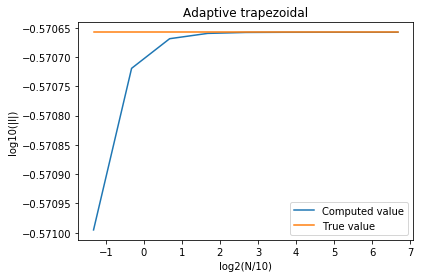

In [9]:
#analytical part
a = 1-np.cos(1)

I_list, N_list = [], []

N = 2
I = integrate_trap(f1, 1e-14, 1, N)
for i in range(9):
    N *= 2
    I_next = 0.5*I + integrate_trap(f1, 1e-14, 1, N, oddterms=True)
    error = (I_next - I)/3
    I_best = I_next + error
    print("N: {}, I: {}, I_next: {}, error: {}, I_best: {}".format(N, I+a, I_next+a, error, I_best+a))
    I = I_next
    I_list.append(I_best+a)
    N_list.append(N)
    
plot(I_list, N_list, "Adaptive trapezoidal", true_f1)

### Romberg integration

In [10]:
#Analytical part
a = 1-np.cos(1)

num_iters = 7
N = 2
R = []

#Get the first order estimates
I = integrate_trap(f1, 1e-14, 1, N)
R.append(I)
for i in range(0, num_iters-1):
    N *= 2
    I_next = 0.5*I + integrate_trap(f1, 1e-14, 1, N, oddterms=True)
    I = I_next
    R.append(I)
    
#Get the higher order estimates
R_ = [value for value in R] #deep copy

for j in range(1, num_iters):
    R_next = [R_[i]+ (R_[i] - R_[i-1])/(4**j-1) for i in range(1,len(R_))]
    
    latest_error = [(R_[i] - R_[i-1])/(4**i-1) for i in range(1,len(R_))][0]
    R_ = R_next
    
print('best romberg estimate: {}, error: {}, depth: {}, N_max: {}'.format(R_[0]+a, latest_error, num_iters, N))

best romberg estimate: 0.26874614626639864, error: 3.677764730721419e-08, depth: 7, N_max: 128


### Simpson's rule
Note: Only an even number of equally spaces sample points to be used

In [11]:
def integrate_simpson(f, lower, upper, N, verbose=False):
    h = abs(upper-lower)/N
    if verbose: print('h = {}'.format(h))
        
    x = np.arange(lower, upper+0.5*h, h, dtype=np.float64)

    if verbose==2: print("points: ", x)
        
    A = f(x)
    
    if verbose: print("scipy integrate: ", integrate.simps(A, dx=h))
    
    args = (f, lower, upper, N)
    T, S = simpsons_odd_terms(*args), simpsons_even_terms(*args)
    result = h*(S.sum() + T.sum()*2)
    
    if verbose: print('my result: ', result)
        
    return result

In [12]:
def simpsons_odd_terms(f, lower, upper, N):
    h = abs(upper-lower)/N
        
    #Odd terms
    x = np.arange(lower+h, upper-0.5*h, 2*h, dtype=np.float64)
    A_odd = f(x)*2/3
    
    return A_odd

def simpsons_even_terms(f, lower, upper, N):
    h = abs(upper-lower)/N
    #Even terms
    x = np.arange(lower, upper+0.5*h, 2*h, dtype=np.float64)
    A_even = f(x)*2/3
    A_even[0] *= 1/2
    A_even[-1] *= 1/2
    
    return A_even

N: 8, I: 0.26853743136551955, I_next: 0.26870803448251424, error: 1.1373541132982574e-05, I_best: 0.26871940802364724
N: 16, I: 0.26870803448251424, I_next: 0.26873934554240114, error: 2.0874039924586215e-06, I_best: 0.26874143294639363
N: 32, I: 0.26873934554240114, I_next: 0.2687449581105153, error: 3.7417120761033357e-07, I_best: 0.2687453322817229
N: 64, I: 0.2687449581105153, I_next: 0.2687459553605239, error: 6.648333390664914e-08, I_best: 0.26874602184385776
N: 128, I: 0.2687459553605239, I_next: 0.2687461319787495, error: 1.1774548373348162e-08, I_best: 0.26874614375329786


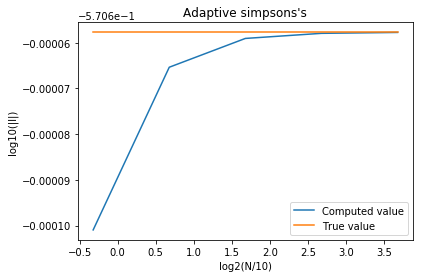

In [13]:
I_list = []
N_list = []

N = 4
l, u = 1e-14, 1
T, S = simpsons_odd_terms(f1, l, u, N).sum(), simpsons_even_terms(f1, l, u, N).sum()
for i in range(1, 6):
    
    h = abs(l-u)/N
    I = h*(S + 2*T)
    
    N *= 2
    
    h_next = abs(l-u)/N
    S_next = S + T
    T_next = simpsons_odd_terms(f1, l, u, N).sum()
    I_next = h_next*(S_next + 2*T_next)
    
    error = (I_next - I)/15
    I_best = I_next + error
    print("N: {}, I: {}, I_next: {}, error: {}, I_best: {}".format(N, I+a, I_next+a, error, I_best+a))
    S, T, I = S_next, T_next, I_next
    
    I_list.append(I_best+a)
    N_list.append(N)
    
plot(I_list, N_list, "Adaptive simpsons's", true_f1)

### Gaussian quadrature

In [14]:
from gaussxw import gaussxwab as g

In [15]:
def integrate_gauss(f, lower, upper, N):
    x, w = g(N, lower, upper)
    return np.sum(w*f(x))

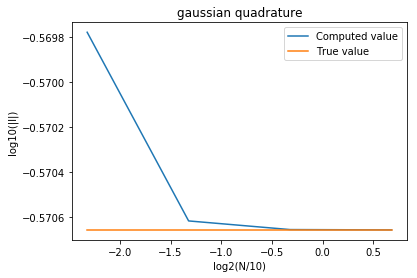

best estimate: 0.2687462038604035, error:3.3928023057683276e-08, N: 16


In [16]:
I = [integrate_gauss(f1, 1e-14, 1, 2**i)+ 1-np.cos(1) for i in range(1,5)]
N = [2**i for i in range(1,5)]
plot(I, N, "gaussian quadrature", true_value=true_f1)
print("best estimate: {}, error:{}, N: {}".format(I[-1], I[-1]-true_f1, N[-1]))

## Non-linear oscillator

theta_m: 0.1,  trapezoid: 20.01567146969629, simpsons's: 15.358790060631367, gauss: 6.262149664319229
theta_m: 0.2,  trapezoid: 34.16861406094757, simpsons's: 24.79783261237048, gauss: 6.274231972193206
theta_m: 0.5,  trapezoid: 76.67150808464756, simpsons's: 53.159607063082625, gauss: 6.357746366548155
theta_m: 1,  trapezoid: 147.6709469918757, simpsons's: 100.59272868989605, gauss: 6.6732569499096845
theta_m: 2,  trapezoid: 290.58008079316045, simpsons's: 196.38363578152035, gauss: 8.313407558734829
theta_m: 3,  trapezoid: 438.5292740228585, simpsons's: 297.36240463024683, gauss: 16.042504279376594


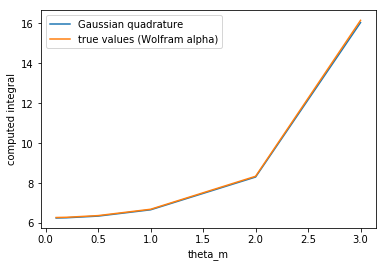

In [18]:
N = 100
I_gauss, I_trap, I_simp = [], [], []
values = [0.1, 0.2, 0.5, 1, 2, 3]
for theta_m in values:
    f = f2_func(theta_m)
    I_gauss.append(integrate_gauss(f, 0, theta_m, N))
    I_trap.append(integrate_trap(f, 0, theta_m, N))
    I_simp.append(integrate_simpson(f, 0, theta_m, N))
    print("theta_m: {},  trapezoid: {}, simpsons's: {}, gauss: {}".format(theta_m, I_trap[-1], I_simp[-1], I_gauss[-1]))
    
plt.plot(values, I_gauss, label='Gaussian quadrature')
plt.plot(values, [6.28711, 6.29893, 6.38279, 6.69998, 8.34975, 16.155], label='true values (Wolfram alpha)')
plt.xlabel('theta_m')
plt.ylabel('computed integral')
plt.legend()
plt.show()